# 泰坦尼克: 从灾难中生存
> 使用机器学习方法预测从泰坦尼克灾难中生存下来的概率

## 第一步: 定义问题
根据船上人员的性别, 年龄, 职业等信息, 设计一种算法来预测泰坦尼克号上的乘客的生存概率

## 第二步: 获取数据
```bash
pip install --upgrade kaggle
```

如果本地没有数据, 则从Kaggle上进行下载. 需要[设置账号和API到
~/.kaggle/kaggle.json](https://github.com/Kaggle/kaggle-api)

```bash
kaggle competitions download -c titanic
```

In [2]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
import sklearn

import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# Input data files are available in the `../dataset/` directory
from subprocess import check_output
print(check_output(['ls', '../dataset']).decode('utf8'))

-------------------------
gender_submission.csv
test.csv
titanic.zip
train.csv



## 加载数据建模库
使用`scikit-learn`库来开发机器学习算法. 在`sklearn`中, 算法被叫做`Estimators`,
实现在他们各自的类里. 对于数据可视化, 使用`matplotlib`和`seaborn`库.

In [3]:
# common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# common model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# configure visualization defaults
# show plots in jupyter notebook inplace
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8


## 了解数据
了解数据的形状(数据类型, 数据值)等等

1. `Survived`代表乘客是否存活
2. `PassengerID`和`Ticket`被假设为随机独立标识符, 对输出没有影响, 因此会被从分析中移除
3. `Pclass`代表票型, 并映射社会经济状态, 表示1 = 上层阶级, 2 = 中层阶级, 3 = 下层阶级;
4. `Name`是名字数据类型, 可能可以在特征工程中根据title判断性别, 从surname中家庭
   大小.
5. `Sex`和`Embarked`变量是命名数据类型. 会被转为dummy变量来进行数学计算.
6. `Age`和`Fare`变量是连续量化数据类型;
7. `SibSp`表示同在船上的兄弟姐妹的数量, `Parch`表示同在船上的父母孩子. 都是离散
   量化数据类型. 可以在特征工程中建立一个家庭大小, 是孤立的变量;
8. `Cabin`变量是命名数据类型, 可以在特征工程中大致定位事故发生时在船上的位置, 以
   及根据等级判断接机. 然而, 犹豫有许多Null值, 该变量用处不大, 被排除在分析之外;

In [4]:
# import data
data_raw = pd.read_csv("../dataset/train.csv")

# break dataset into train, test and validation
# the test file provided is the validation file for competition submission
# split the train set into train and test data
data_val = pd.read_csv("../dataset/test.csv")

# to play with our data, create a copy
# python assignment or equal passes by reference vs vslues
data1 = data_raw.copy(deep=True)

# however passing by reference is convenient, because learn both datasets at
# once
data_cleaner = [data1, data_val]

# preview data
print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
135,136,0,2,"Richard, Mr. Emile",male,23.0,0,0,SC/PARIS 2133,15.0458,NaN,C
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",male,51.0,0,0,347064,7.7500,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
769,770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32.0,0,0,8471,8.3625,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
400,401,1,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S


### 数据清理: 数据纠正, 数据补全, 数据创建和数据转换
在该阶段中, 
1) 修正不正常数据和离群数据, 
2) 完成丢失的信息, 
3) 为分析创建新的
特征, 
4) 转换数据到正确的格式以用于计算和表示

In [5]:
print('Train columns with null values:\n', data1.isnull().sum())
print('-'*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print('-'*10)

data_raw.describe(include='all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
# completing: complete or delete missing values in train and test/validation
# dataset
for dataset in data_cleaner:
    # complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    
    # complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    # complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    
# delete the cabin feature/column and others previously stated to exclude in
# train dataset
drop_column=['PassengerId','Cabin','Ticket']
data1.drop(drop_column,axis=1,inplace=True)

print(data1.isnull().sum())
print('-'*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
# create: feature engineering for train and test/validation dataset
for dataset in data_cleaner:
    # discrete variables
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

    dataset["IsAlone"] = 1  # initialize to yes/1 is alone
    dataset["IsAlone"].loc[
        dataset["FamilySize"] > 1
    ] = 0  # now update to no/0 if family size is greater than 1

    # quick and dirty code split title from name
    dataset["Title"] = (
        dataset["Name"]
        .str.split(", ", expand=True)[1]
        .str.split(".", expand=True)[0]
    )

    # continuous variable bins using qcut, cut into bins with approximately
    # equal amount of elements
    dataset["FareBin"] = pd.qcut(dataset["Fare"], 4)

    # age bins/buckets using cut with the same interval of each bin
    dataset["AgeBin"] = pd.cut(dataset["Age"].astype(int), 5)

# cleanup rare title names
print(data1["Title"].value_counts())
stat_min = (
    10  # while small is arbitrary, we'll use the common minimum in statistics
)
title_names = (
    data1["Title"].value_counts() < stat_min
)  # this will create a true false series with title name as index

# apply and lambda functions are quick and dirty code to find and replace with
# fewer lines of code
data1["Title"] = data1["Title"].apply(
    lambda x: "Misc" if title_names.loc[x] == True else x
)
print(data1['Title'].value_counts())
print('-'*10)

# preview data again
data1.info()
data_val.info()
data1.sample(10)

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
Title
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: count, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
499,0,3,"Svensson, Mr. Olof",male,24.0,0,0,7.7958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
127,1,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,7.1417,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
340,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,26.0000,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
165,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,20.5250,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
376,1,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,7.2500,S,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
63,0,3,"Skoog, Master. Harald",male,4.0,3,2,27.9000,S,6,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
44,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,7.8792,Q,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
860,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,14.1083,S,3,0,Mr,"(7.91, 14.454]","(32.0, 48.0]"
371,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,6.4958,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
877,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"


### 转换格式

将类别数据转换成 dummy 变量, 用于数学分析.

此外, 为数据建模定义 x(independent/features/explanatory/predictor/etc.)和 y(dependent/target/outcome/response/etc.)变量


In [8]:
# convert: convert objects to categoryusiing Label Encoder for train and
# test/validation dataset

# code categorical data
label = LabelEncoder()
for dataset in data_cleaner:
    dataset["Sex_Code"] = label.fit_transform(dataset["Sex"])
    dataset["Embarked_Code"] = label.fit_transform(dataset["Embarked"])
    dataset["Title_Code"] = label.fit_transform(dataset["Title"])
    dataset["FareBin_Code"] = label.fit_transform(dataset["FareBin"])
    dataset["AgeBin_Code"] = label.fit_transform(dataset["AgeBin"])

# define y variable aka target/outcome
Target = ["Survived"]

# define x variables for original features aka feature selection
data1_x = [
    "Sex",
    "Pclass",
    "Embarked",
    "Title",
    "SibSp",
    "Parch",
    "Age",
    "Fare",
    "FamilySize",
    "IsAlone",
]  # pretty name/values for charts
data1_x_calc = [
    "Sex_Code",
    "Pclass",
    "Embarked_Code",
    "Title_Code",
    "SibSp",
    "Parch",
    "Age",
    "Fare",
]  # code for algorithm calculation

# define x variables original w/bin features to remove continuous variables
data1_x_bin = [
    "Sex_Code",
    "Pclass",
    "Embarked_Code",
    "Title_Code",
    "FamilySize",
    "AgeBin_Code",
    "FareBin_Code",
]
data1_xy_bin = Target + data1_x_bin
print("Bin X Y: ", data1_xy_bin, "\n")

# define x and y variables for dummy features original
data1_dummy=pd.get_dummies(data1[data1_x])
data1_x_dummy=data1_dummy.columns.tolist()
data1_xy_dummy=Target+data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,False,True,False,False,True,False,False,False,True,False
1,1,1,0,38.0,71.2833,2,0,True,False,True,False,False,False,False,False,False,True
2,3,0,0,26.0,7.9250,1,1,True,False,False,False,True,False,False,True,False,False
3,1,1,0,35.0,53.1000,2,0,True,False,False,False,True,False,False,False,False,True
4,3,0,0,35.0,8.0500,1,1,False,True,False,False,True,False,False,False,True,False


### Da-Double 检测清理后数据
清理数据后, 进行一次折扣da-double检测

In [9]:
print('Train columns with null values: \n', data1.isnull().sum())
print('-'*10)
print(data1.info())
print('-'*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print('-'*10)
print(data_val.info())
print('-'*10)

data_raw.describe(include='all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
FareBin_Code     0
AgeBin_Code      0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 划分训练和测试数据
Kaggle提供的测试文件实际上是验证数据, 因此使用`sklearn1`的函数来将训练数据划分为
两个数据集, 75/25划分. 这样做可以避免模型的过拟合.

In [10]:
# split train and test data with function defaults
# random_state: seed of random number generator
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(
    data1[data1_x_calc], data1[Target], random_state=42
)
(
    train1_x_bin,
    test1_x_bin,
    train_y_bin,
    test1_y_bin,
) = model_selection.train_test_split(
    data1[data1_x_bin], data1[Target], random_state=42
)
(
    train1_x_dummy,
    test1_x_dummy,
    train1_y_dummy,
    test1_y_dummy,
) = model_selection.train_test_split(
    data1_dummy[data1_x_dummy], data1[Target], random_state=42
)

print('Data1 shape[{}]'.format(data1.shape))
print('Train1 shape[{}]'.format(train1_x.shape))
print('Test1 shape[{}]'.format(test1_x.shape))

train1_x_bin.head()

Data1 shape[(891, 19)]
Train1 shape[(668, 8)]
Test1 shape[(223, 8)]


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
298,1,1,2,3,1,1,2
884,1,3,2,3,1,1,0
247,0,2,2,4,3,1,2
478,1,3,2,3,1,1,0
305,1,1,2,0,4,0,3


## 第四步: 执行探索分析与统计
数据已经清理完成, 可以使用描述性和图形性的统计来探索我们的数据, 描述和总结我们的
变量.

In [11]:
# discrete variable correlation by survival using group by pivot table
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by: ', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        
# using crosstabs
print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by:  FamilySize
   FamilySize  Survived
0           1  0.30

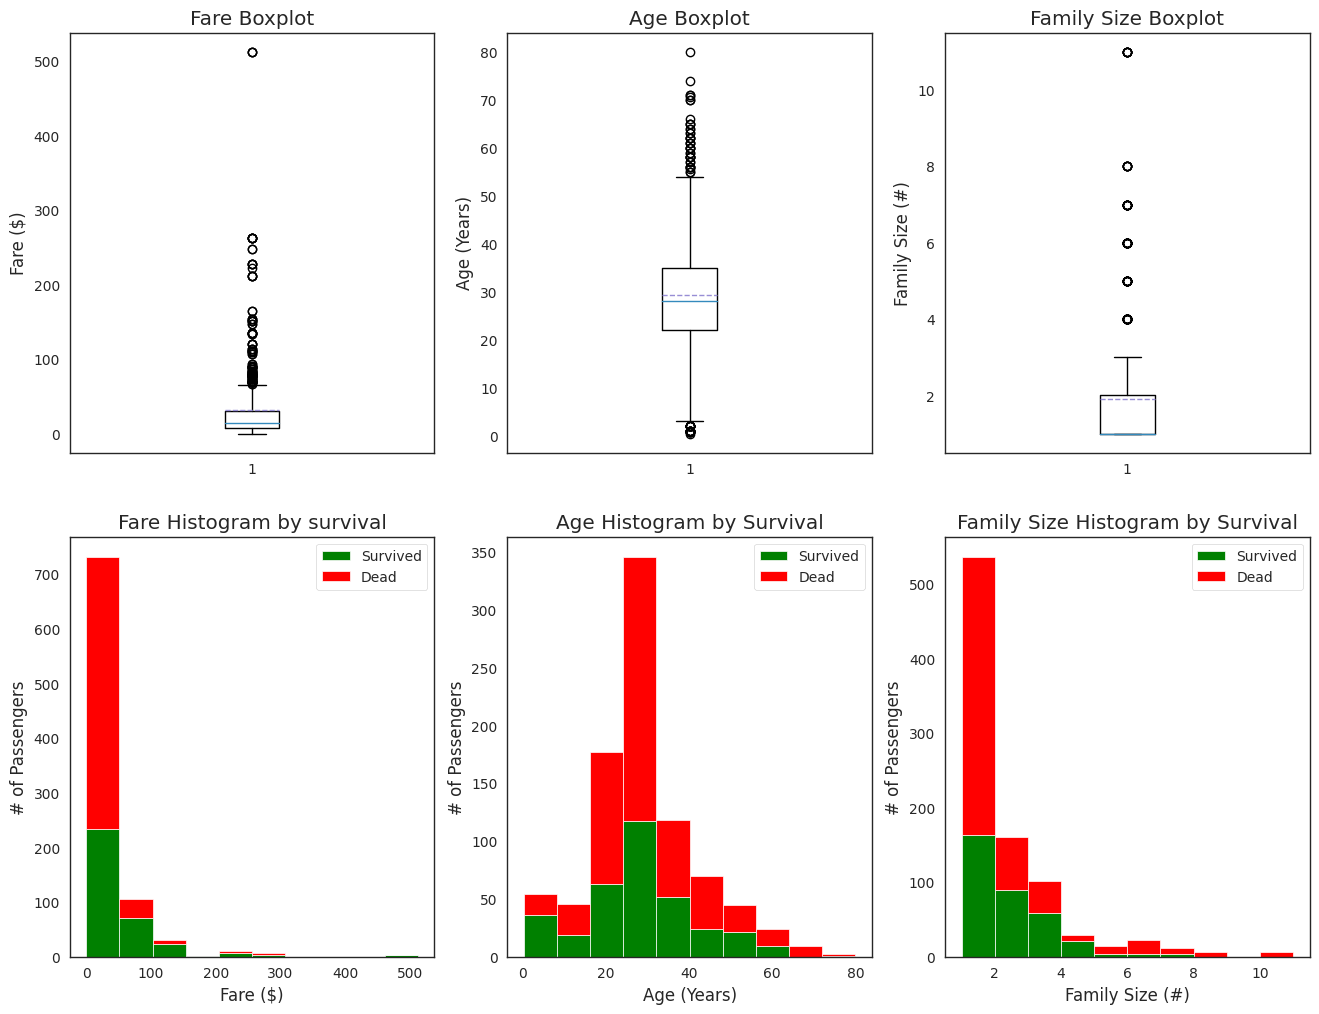

In [12]:
# graph distribution of quantative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans=True,meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans=True,meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x=[data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']],stacked=True,color=['g','r'],label=['Survived','Dead'])
plt.title('Fare Histogram by survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x=[data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], stacked=True, color=['g','r'],label=['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x=[data1[data1['Survived']==1]['FamilySize'],data1[data1['Survived']==0]['FamilySize']],stacked=True,color=['g','r'],label=['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

<Axes: xlabel='FamilySize', ylabel='Survived'>

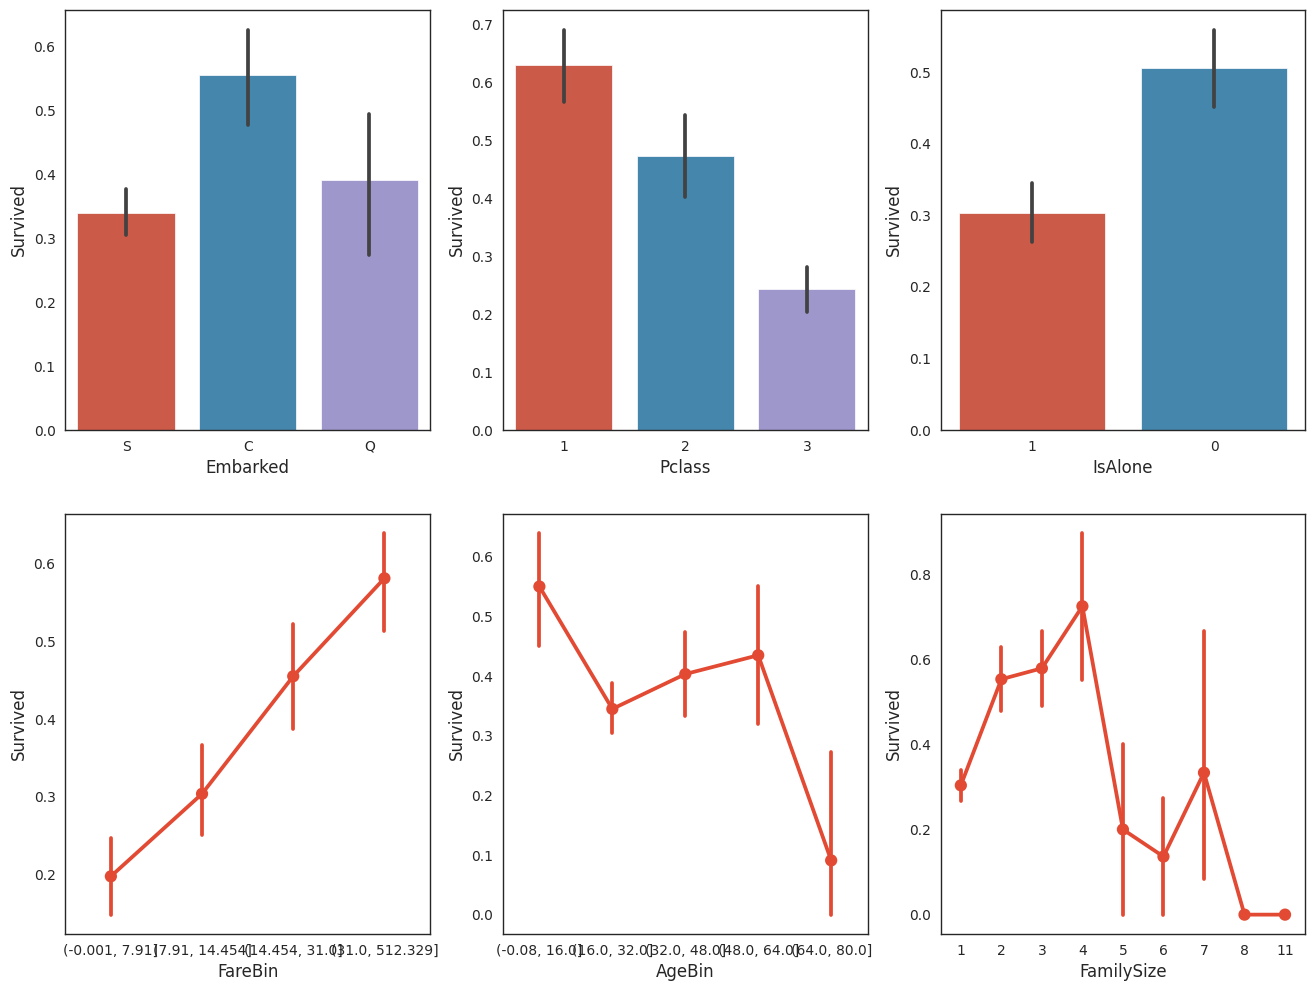

In [13]:
# use seaborn graphics for multi-variable comparision:

# graph individual features by survival
fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x='Embarked',y='Survived',data=data1,ax=saxis[0,0])
sns.barplot(x='Pclass',y='Survived',order=[1,2,3],data=data1,ax=saxis[0,1])
sns.barplot(x='IsAlone',y='Survived',order=[1,0],data=data1,ax=saxis[0,2])

sns.pointplot(x='FareBin',y='Survived',data=data1,ax=saxis[1,0])
sns.pointplot(x='AgeBin',y='Survived',data=data1,ax=saxis[1,1])
sns.pointplot(x='FamilySize',y='Survived',data=data1,ax=saxis[1,2])

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparision')

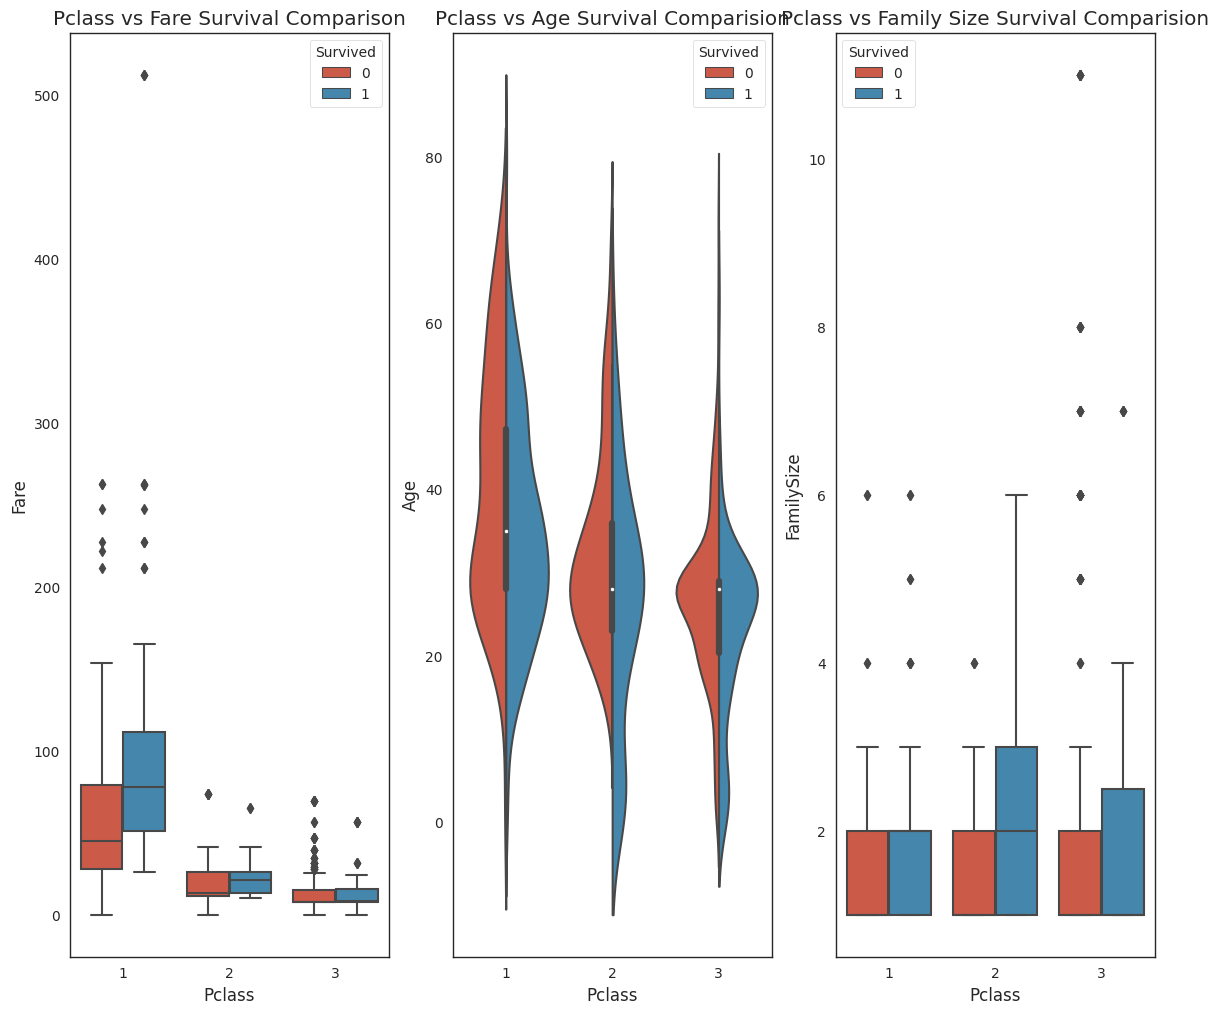

In [14]:
# graph distribution of qualitative data: Pclass
# compare class and a 2nd feature
fig, (axis1, axis2, axis3)=plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x='Pclass',y='Fare',hue='Survived',data=data1,ax=axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x='Pclass',y='Age',hue='Survived',data=data1,split=True,ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparision')

sns.boxplot(x='Pclass',y='FamilySize',hue='Survived',data=data1,ax=axis3)
axis3.set_title('Pclass vs Family Size Survival Comparision')

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparision')

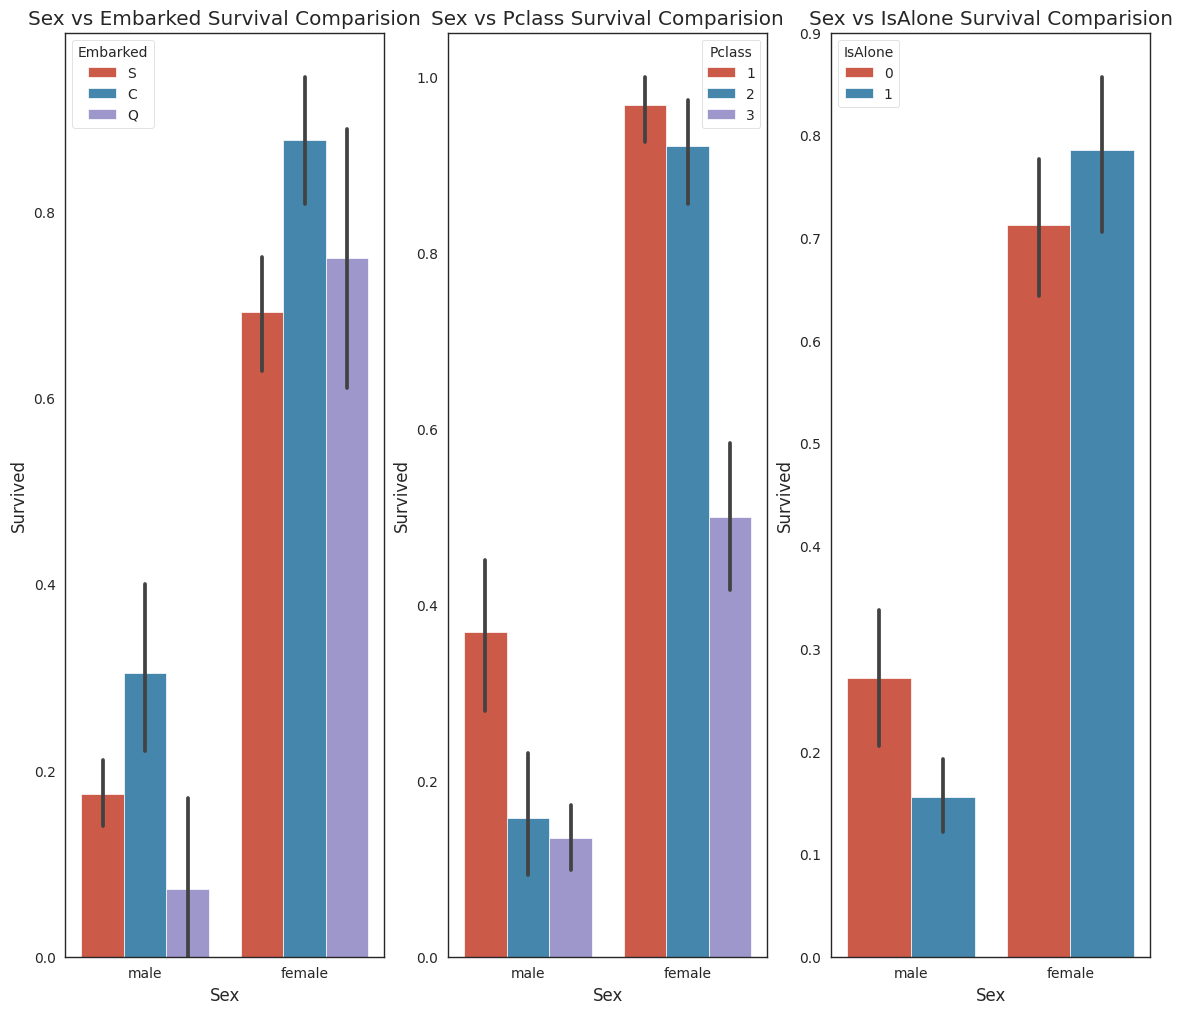

In [15]:
# graph distribution of qualitative data: Sex
# compare sex and a 2nd feature
fig, qaxis=plt.subplots(1,3,figsize=(14,12))

sns.barplot(x='Sex',y='Survived',hue='Embarked',data=data1,ax=qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparision')

sns.barplot(x='Sex',y='Survived',hue='Pclass',data=data1,ax=qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparision')

sns.barplot(x='Sex',y='Survived',hue='IsAlone',data=data1,ax=qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparision')


<Axes: xlabel='Pclass', ylabel='Survived'>

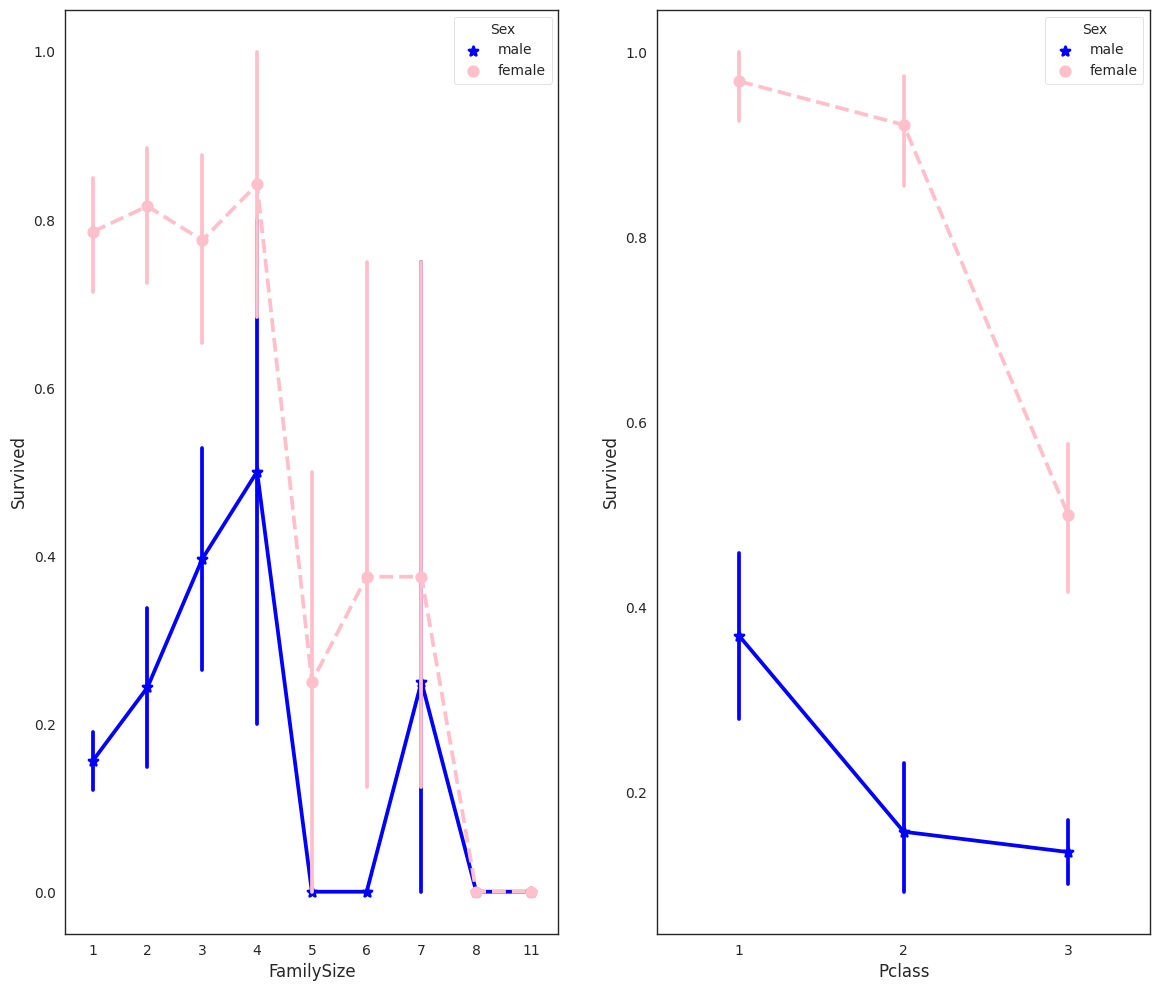

In [16]:
# more side-by-side comparisions
fig, (maxis1,maxis2)=plt.subplots(1,2,figsize=(14,12))

# how does family size factor with sex and sirvival compare
sns.pointplot(x='FamilySize',y='Survived',hue='Sex',data=data1,palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'],ax=maxis1)

# how does class factor with sex and survival compare
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data1,palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'],ax=maxis2)

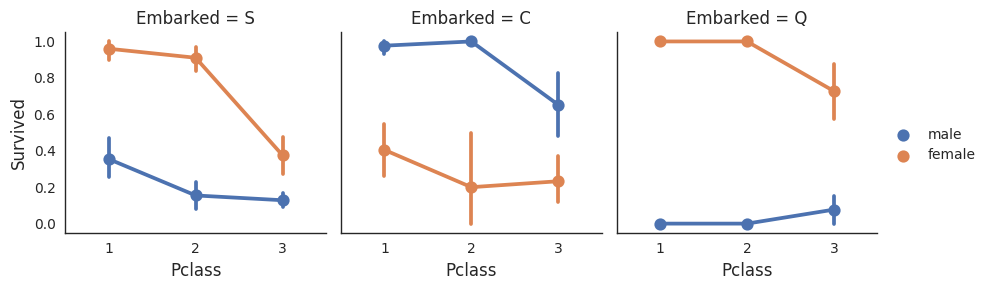

In [17]:
# how does embark port factor with class, sex, and survival compare
e=sns.FacetGrid(data1,col='Embarked')
e.map(sns.pointplot,'Pclass','Survived','Sex',ci=95.0,palette='deep')
e.add_legend()

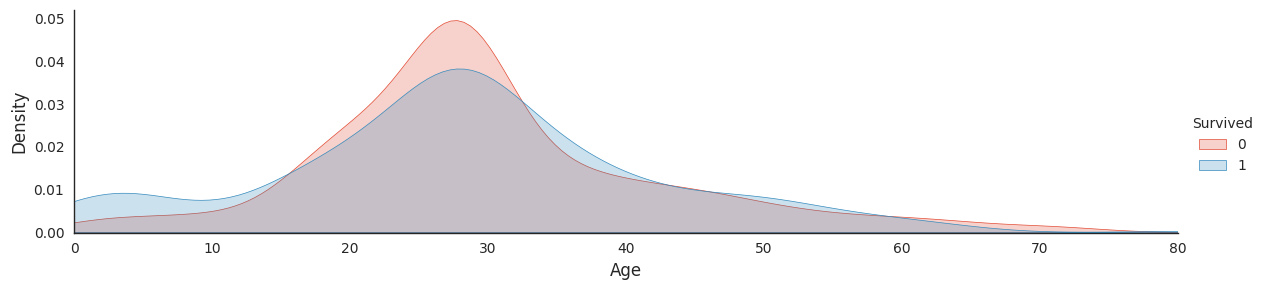

In [18]:
# plot distributions of age of passengers who survived or did not survive
a=sns.FacetGrid(data1,hue='Survived',aspect=4)
a.map(sns.kdeplot,'Age',shade=True)
a.set(xlim=(0,data1['Age'].max()))
a.add_legend()

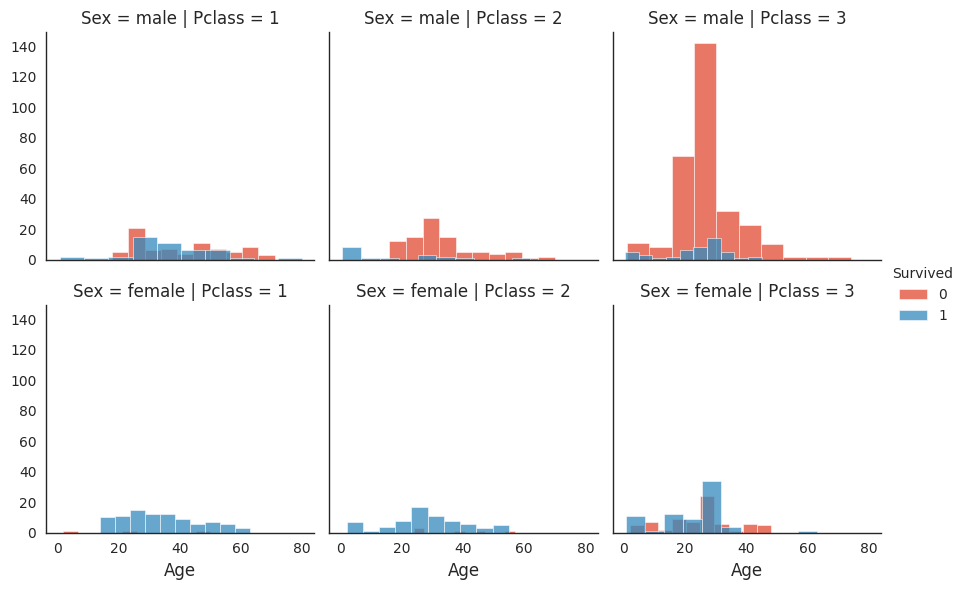

In [19]:
# historical comparision of sex, class and age by survival
h=sns.FacetGrid(data1,row='Sex',col='Pclass',hue='Survived')
h.map(plt.hist,'Age',alpha=.75)
h.add_legend()

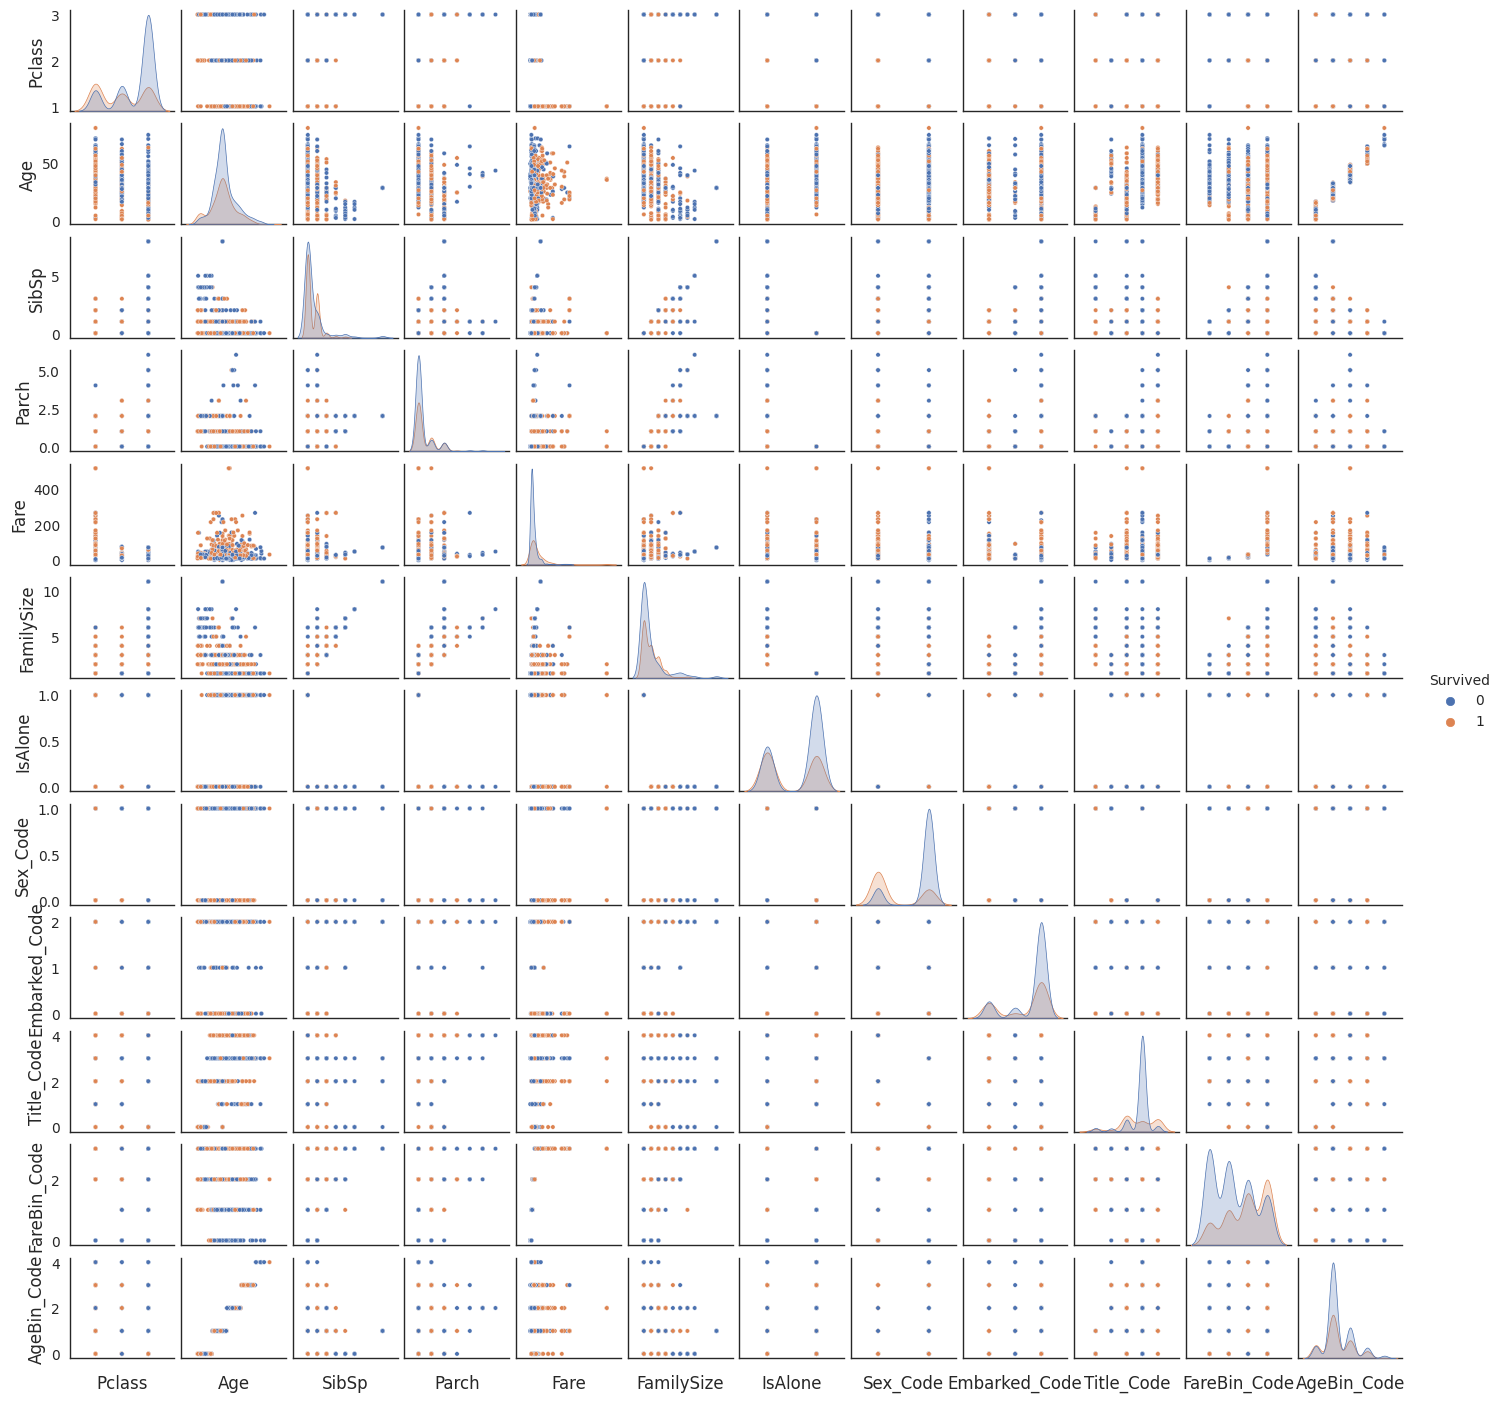

In [20]:
# pair plots of entire dataset
pp=sns.pairplot(data1,hue='Survived',palette='deep',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
pp.set(xticklabels=[])

相关系数以 Pearson 相关性公式计算

$$
\text{{corr}}(X, Y) = \frac{\sum_{x=1}^n{(x_i-\text{mean}(X))*(y_i-\text{mean}(Y))}}{(n-1)*\text{std}(X)*\text{std}(Y)}
$$


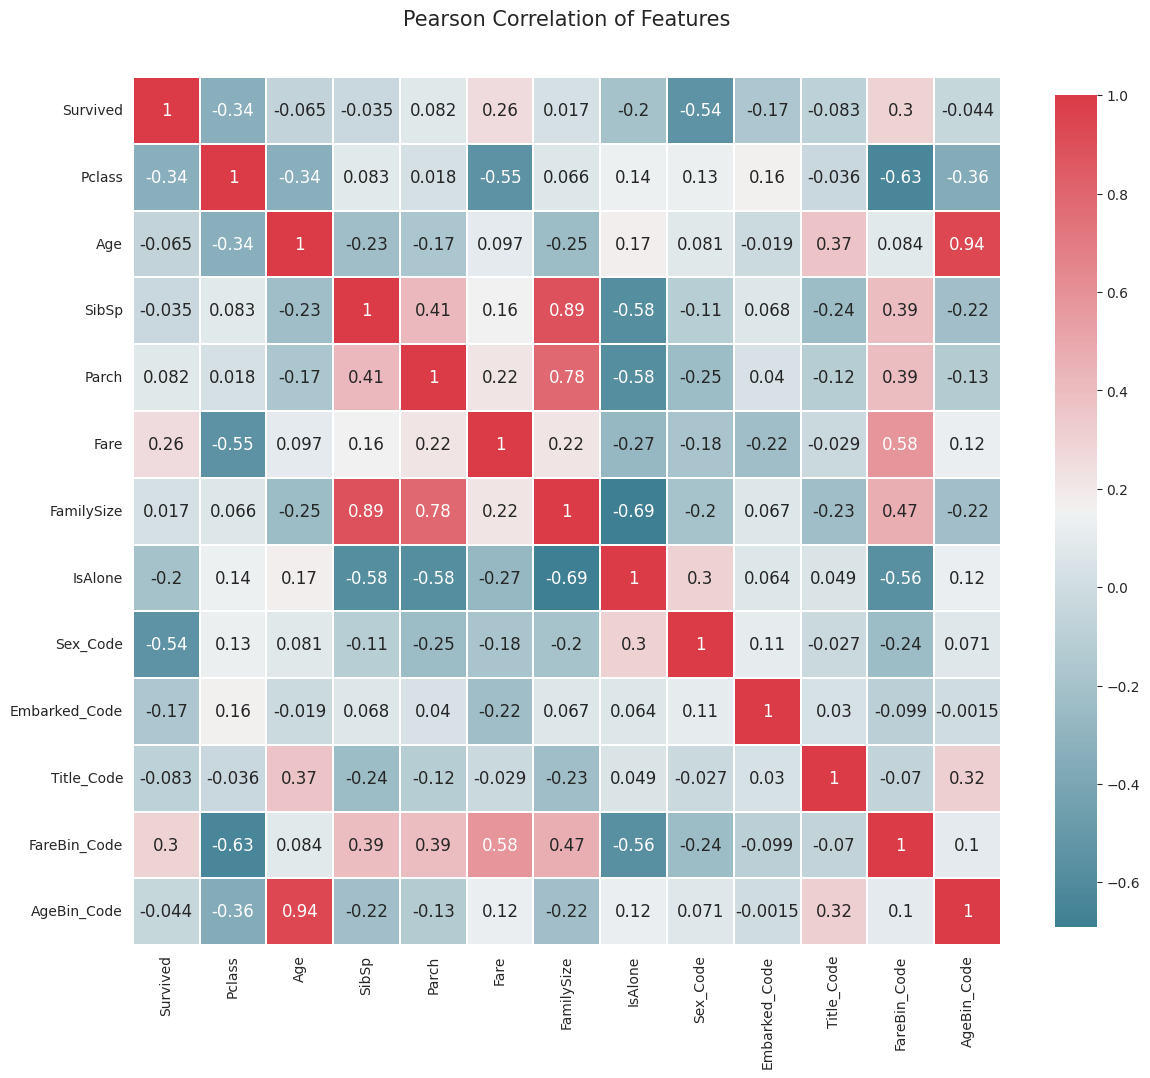

In [21]:
# correlation heatmap of dataset
# ignore not-number columns, because they cannot be converted to float type
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    numeric_cols = df.select_dtypes(
        include=[np.number]
    )  # only select numeric columns

    _ = sns.heatmap(
        numeric_cols.corr(),
        cmap=colormap,
        square=True,
        cbar_kws={"shrink": 0.9},
        ax=ax,
        annot=True,
        linewidths=0.1,
        vmax=1.0,
        linecolor="white",
        annot_kws={"fontsize": 12},
    )

    plt.title("Pearson Correlation of Features", y=1.05, size=15)


correlation_heatmap(data1)

## 第五步: 数据建模
使用监督机器学习. 对于机器学习算法的选择, 机器学习算法有四中类别: 分类, 回归, 成
簇, 降维. 对于本次的任务, 生存与否是离散的目标变量, 因此使用分类算法来进行分析.
使用交叉验证和评分矩阵来排序和比较几种不同算法的表现.

本次实验中选择的算法列表:
- Ensemble Methods, 集成算法
- Generalized Linear Models, 广义线性模型
- Naive Bayes, 朴素贝叶斯
- Nearest Neighbors, 最近邻居
- Support Vector Machines, 支持向量机
- Decision Trees, 决策树
- Discriminant Analysis, 判别分析法

In [22]:
# machine learning algorithms (MLA) selection and Initialization
MLA = [
    # ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    # XGBoost
    XGBClassifier(),
]

# split dataset in cross-validation
# this is a alternative to train_test_split
cv_split = model_selection.ShuffleSplit(
    n_splits=10, test_size=0.3, train_size=0.6, random_state=0
)

# create table to compare MLA metrics
MLA_columns = [
    "MLA Name",
    "MLA Paramaters",
    "MLA Train Accuracy Mean",
    "MLA Test Accuracy Mean",
    "MLA Test Accuracy 3*STD",
    "MLA Time",
]
MLA_compare = pd.DataFrame(columns=MLA_columns)

# create table to compare MLA predictions
MLA_predict = data1[Target]

# index through MLA and save performance to table
row_index = 0
for alg in MLA:
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, "MLA Name"] = MLA_name
    MLA_compare.loc[row_index, "MLA Parameters"] = str(alg.get_params())

    # score model with cross validation
    cv_results = model_selection.cross_validate(
        alg,
        data1[data1_x_bin],
        data1[Target],
        cv=cv_split,
        return_train_score=True,
    )

    MLA_compare.loc[row_index, "MLA Time"] = cv_results["fit_time"].mean()
    MLA_compare.loc[row_index, "MLA Train Accuracy Mean"] = cv_results[
        "train_score"
    ].mean()
    MLA_compare.loc[row_index, "MLA Test Accuracy Mean"] = cv_results[
        "test_score"
    ].mean()
    # if this is a non-bias random sample, then +/-3 standard deviations(std)
    # from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, "MLA Test Accuracy 3*STD"] = (
        cv_results["test_score"].std() * 3
    )  # the worst that can happen

    # save MLA predictions
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])

    row_index += 1

# print and sort table
MLA_compare.sort_values(
    by=["MLA Test Accuracy Mean"], ascending=False, inplace=True
)
MLA_compare
# MLA_predict

,MLA Name,MLA Paramaters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA Parameters
4,RandomForestClassifier,NaN,0.895131,0.830224,0.058004,0.069144,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
14,SVC,NaN,0.835206,0.827612,0.040916,0.02194,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
21,XGBClassifier,NaN,0.890449,0.826493,0.06177,0.049823,"{'objective': 'binary:logistic', 'use_label_en..."
15,NuSVC,NaN,0.834082,0.826119,0.045663,0.0257,"{'break_ties': False, 'cache_size': 200, 'clas..."
2,ExtraTreesClassifier,NaN,0.895131,0.824254,0.055396,0.052665,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
3,GradientBoostingClassifier,NaN,0.866667,0.822761,0.049873,0.047364,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
1,BaggingClassifier,NaN,0.890824,0.820149,0.06024,0.011894,"{'base_estimator': 'deprecated', 'bootstrap': ..."
17,DecisionTreeClassifier,NaN,0.895131,0.819403,0.054426,0.001861,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
0,AdaBoostClassifier,NaN,0.820412,0.81194,0.049861,0.043669,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
5,GaussianProcessClassifier,NaN,0.871723,0.810448,0.049254,0.150104,"{'copy_X_train': True, 'kernel': None, 'max_it..."


Text(0, 0.5, 'Algorithm')

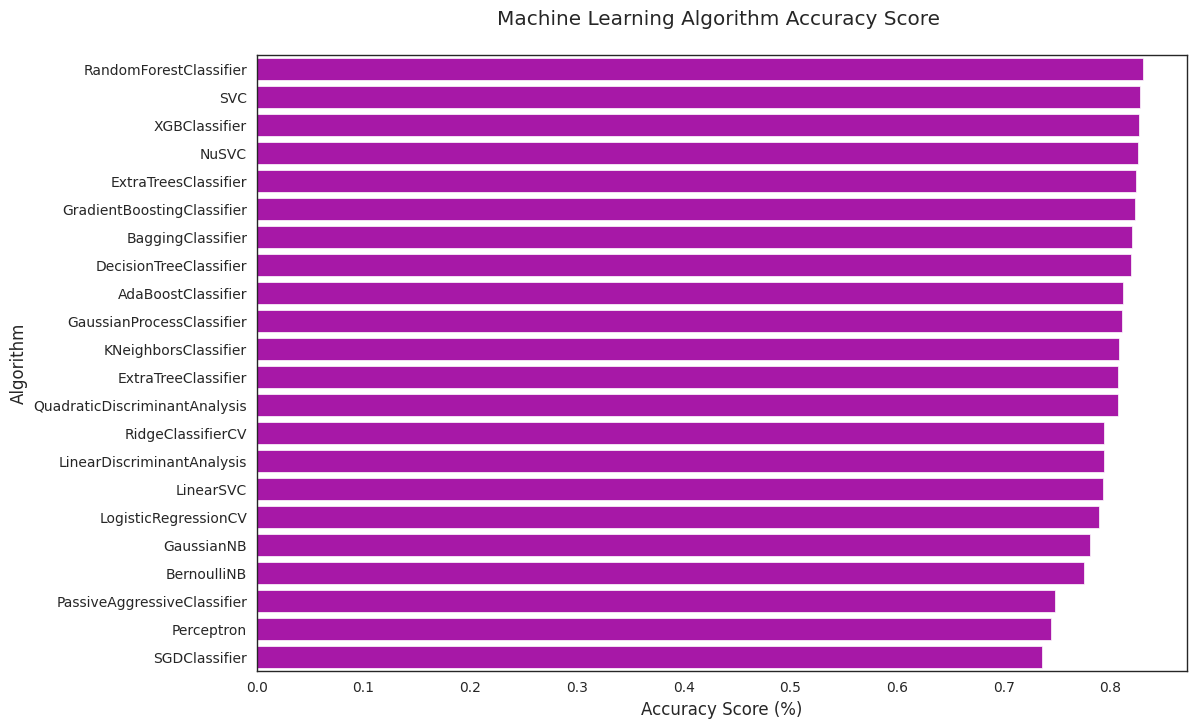

In [23]:
# barplot
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')

# prettify using pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## 评价模型表现
借助前面的数据清理, 分析和选择的机器学习算法, 几行代码就获得了82%左右的准确率.
但是是不是可以做的更好, 或者获取更高的投资回报比?

### 设立合理的基线(baseline)
在泰坦尼克号上1502/2224, 即67.5%的人死掉了. 如果我们仅仅假设所有人都死掉了, 也可
以获得67.5%的准确率. 因此, 基线需要设置在至少67.5%, 即模型的最坏表现应该高于
67.5%才有意义.

## 借助超参数调节模型
在使用决策树分类器的时候, 使用了所有的默认设置. 这给了我们查看不同超参数设置对模
型精确度影响的机会.

然而, 为了调节一个模型, 需要弄懂他. 为了调节决策树模型, 我们需要了解一下这个模型
.

**决策树的一些优点**
- 简单易懂, 树可以被可视化;
- 需要很少的数据准备. 另外的技巧一般需要数据规范化, dummy变量需要被创建, 空值
  需要被删除. 注意这个模块不支持缺失值;
- 使用决策树(预测数据)的开销相对于用来训练树的数据点是对数级的;
- 可以处理数字和类别数据. 其他的技巧通常只能用于分析只具有一种类型变量的数据集;
- 可以处理多输出问题;
- 使用白盒模型. 如果一个给定的情况在一个模型中可以被看到, 对该情况的解释可以很容
易的用布尔逻辑进行解释. 相反的, 一个黑盒模型(例如一个人工神经网络), 结果会更难推测;
- 可以使用统计测试来验证一个模型. 这使得承诺模型的可靠性成为可能;
- 即便与数据生成的真是模型的假设有些出入, 表现仍旧很好;
**决策树的一些缺点:**
- 决策树学习者可以创建过于复杂的树, 因此不能再数据上泛化良好. 这被叫做**过拟合
  **. 例如剪枝(目前没有支持), 设置在一个叶子节点需要的最少数量样本, 或者设置树的
  最大深度等等机制都是避免这一问题的必要方法;
- 由于数据中的很小的偏差可能导致生成完全不同的树, 因此决策树可能十分不稳定. 这个问题可以借助多个决策树一起决策来缓解;
- 学习一个最优决策树被认为是NP完备的, 在几个优化角度下, 即便对于简单的概念. 因
  此, 可行的决策树学习算法都基于启发算法的, 例如贪心算法. 在这种情况下在每个节点
  得到的都是局部最优决策. 这样的算法不能保证返回全局最优的决策树. 但使用一个集成
  学习器可以减小, 其中特征和样本被随机取样.
- 有些概念难以被学习到, 因为决策树不显式的容易的表达他们, 例如异或, 偏序或者倍乘问题.
- 决策树学习器创建有偏见的树, 如果一些类占统治地位. 因此推荐对数据集进行平衡来让他适合决策树.

下面将使用PrameterGrid, GridSearchCV, 自定义的sklearn scoring来调节模型. 借助graphviz来可视化决策树.

In [24]:
# base model
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(
    dtree,
    data1[data1_x_bin],
    data1[Target],
    cv=cv_split,
    return_train_score=True,
)
dtree.fit(data1[data1_x_bin], data1[Target])

print("BEFORE DT Parameters: ", dtree.get_params())
print(
    "BEFORE DT Training w/bin score mean: {:.2f}".format(
        base_results["train_score"].mean() * 100
    )
)
print(
    "BEFORE DT Test w/bin score mean: {:.2f}".format(
        base_results["test_score"].mean() * 100
    )
)
print(
    "BEFORE DT Test w/bin score 3*std: +/- {:.2f}".format(
        base_results["test_score"].std() * 100 * 3
    )
)
print("-" * 10)

# tune hyper-parameters:
param_grid = {
    "criterion": [
        "gini",
        "entropy",
    ],  # scoring methodology; two supported formulas for calcularing information gain. default is gini
    "max_depth": [
        2,
        4,
        6,
        7,
        10,
        None,
    ],  # max depth tree can grow; defualt is None
    "random_state": [0],
}


# choose best model with grid_search
tune_model = model_selection.GridSearchCV(
    tree.DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_split,
    return_train_score=True
)
tune_model.fit(data1[data1_x_bin], data1[Target])

print("AFTER DT Parameters: ", tune_model.best_params_)
print(
    "AFTER DT Training w/bin socre mean: {:.2f}".format(
        tune_model.cv_results_["mean_train_score"][tune_model.best_index_] * 100
    )
)
print(
    "AFTER DT Test w/bin score mean: {:.2f}".format(
        tune_model.cv_results_["mean_test_score"][tune_model.best_index_] * 100
    )
)
print(
    "AFTER DT Test w/bin score 3*std: +/- {:.2f}".format(
        tune_model.cv_results_["std_test_score"][tune_model.best_index_]
        * 100
        * 3
    )
)
print("-" * 10)

BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------


AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin socre mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


## 借助特征选择来微调模型
和在开头说过的一样, 更多的预测器变量并不能获得一个更好的模型, 但是正确的预测器可
以. 因此在数据建模中的另一步是特征选择. Sklearn中有多个选项, 其中这里使用递归特
征消除(Recursive feature elimination, RFE)和交叉验证(Cross validation, CV)

In [25]:
# base model
print("BEFORE DT RFE Training Shape Old: ", data1[data1_x_bin].shape)
print("BEFORE DT RFE Training Columns Old: ", data1[data1_x_bin].columns.values)

print(
    "BEFORE DT RFE Training w/bin score mean: {:.2f}".format(
        base_results["train_score"].mean() * 100
    )
)
print(
    "BEFORE DT RFE Test w/bin score mean: {:.2f}".format(
        base_results["test_score"].mean() * 100
    )
)
print(
    "BEFORE DT RFE Test w/bin score 3*std: {:.2f}".format(
        base_results["test_score"].std() * 100 * 3
    )
)
print("-" * 10)

# feature selection
dtree_rfe = feature_selection.RFECV(
    dtree, step=1, scoring="accuracy", cv=cv_split
)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

# transform x&y to reduced features and fit new model
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(
    dtree, data1[X_rfe], data1[Target], cv=cv_split, return_train_score=True
)

print("AFTER DT RFE Training Shape New: ", data1[X_rfe].shape)
print("AFTER DT RFE Training Columns New: ", X_rfe)

print(
    "AFTER DT RFE Training w/bin score mean: {:.2f}".format(
        rfe_results["train_score"].mean() * 100
    )
)
print(
    "AFTER DT RFE Test w/bin score mean: {:.2f}".format(
        rfe_results["test_score"].mean() * 100
    )
)
print(
    "AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}".format(
        rfe_results["test_score"].std() * 100 * 3
    )
)
print("-" * 10)

# ture rfe model
rfe_tune_model = model_selection.GridSearchCV(
    tree.DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_split,
    return_train_score=True,
)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

print("AFTER DT RFE Tuned Parameters: ", rfe_tune_model.best_params_)
print(
    "AFTER DT RFE Tuned Training w/bin score mean: {:.2f}".format(
        rfe_tune_model.cv_results_["mean_train_score"][tune_model.best_index_]
        * 100
    )
)
print(
    "AFTER DT RFE Tuned Test w/bin score mean: {:.2f}".format(
        rfe_tune_model.cv_results_["mean_test_score"][tune_model.best_index_]
        * 100
    )
)
print(
    "AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}".format(
        rfe_tune_model.cv_results_["std_test_score"][tune_model.best_index_]
        * 100
        * 3
    )
)
print("-" * 10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


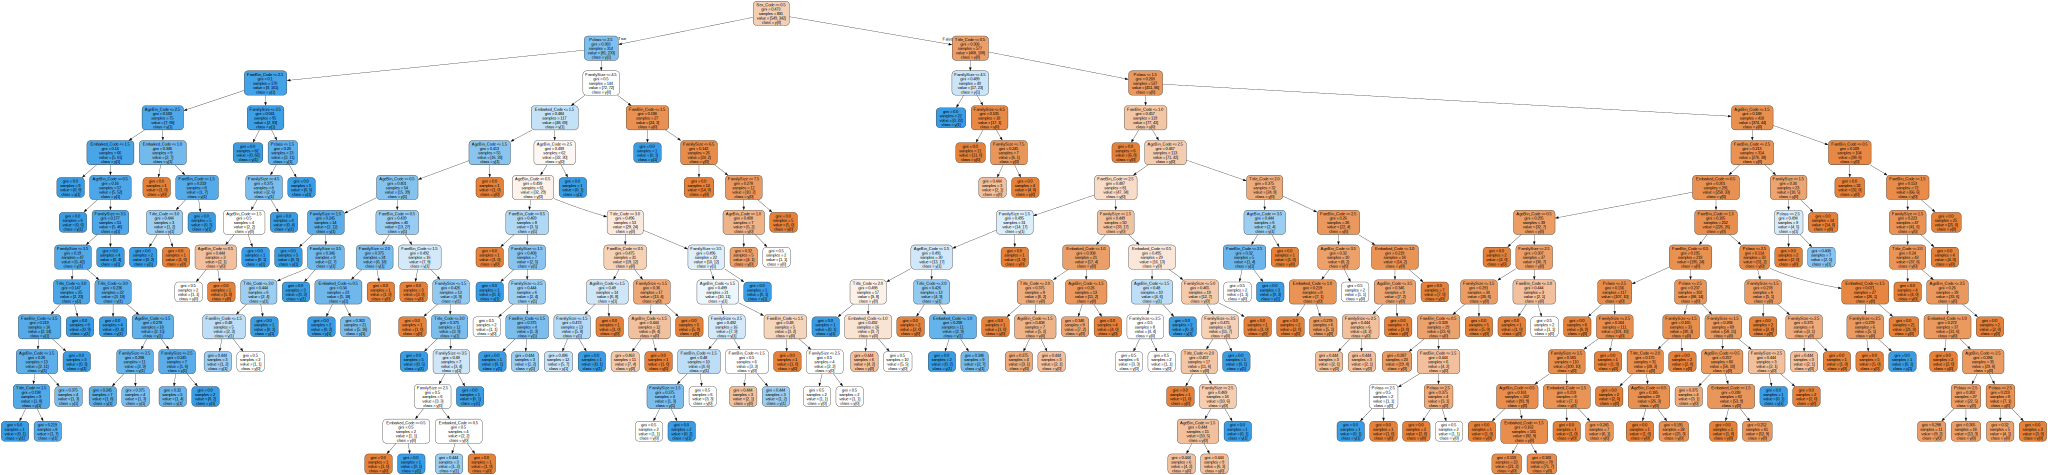

In [31]:
# graph MLA version of Decision Tree
import graphviz

dot_data = tree.export_graphviz(
    dtree,
    out_file=None,
    feature_names=data1_x_bin,
    class_names=True,
    filled=True,
    rounded=True,
)
graph = graphviz.Source(dot_data)
graph

# 第六步: 验证和实现
使用模型对验证数据进行预测

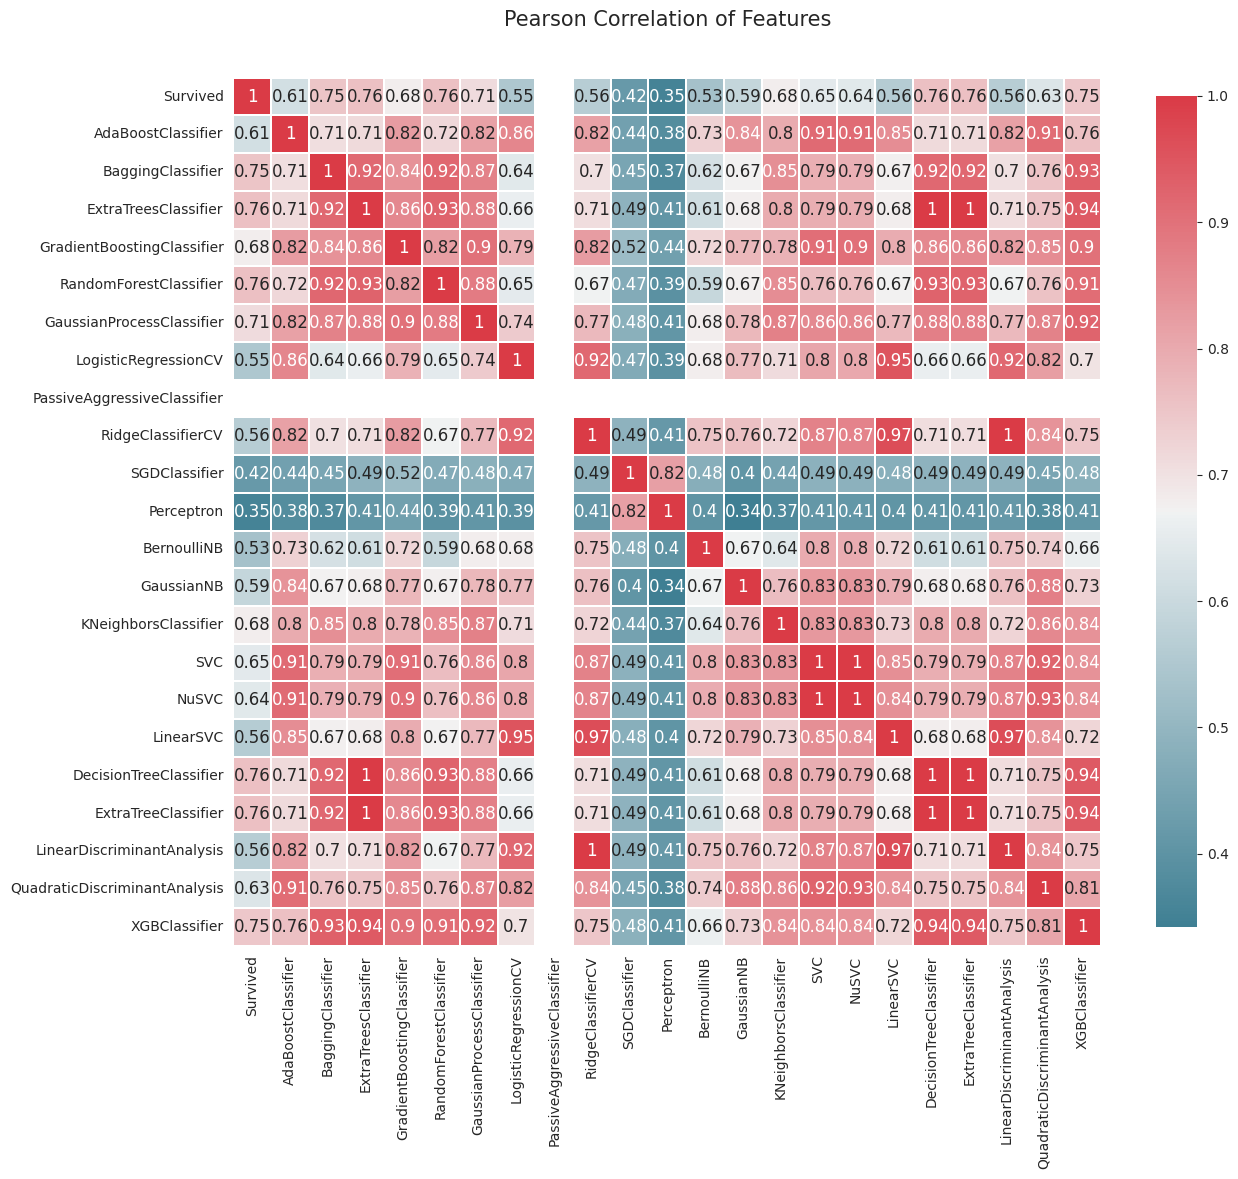

In [32]:
# compare algorithm predictions with each other, where 1 = exactly similar and 0
# = exactly opposite
# there are some 1's, but enough blues and light reds to create a 'super
# algorithm' by combining them
correlation_heatmap(MLA_predict)

In [34]:
# why choose one model, when you can pick them all with voting classifier
# removed models w/o attribute 'predict_proba' required for vote classifier and
# models with a 1.0 correlation to another model
vote_est = [
    # Ensemble Methods
    ("ada", ensemble.AdaBoostClassifier()),
    ("bc", ensemble.BaggingClassifier()),
    ("etc", ensemble.ExtraTreesClassifier()),
    ("gbc", ensemble.GradientBoostingClassifier()),
    ("rfc", ensemble.RandomForestClassifier()),
    # Gaussian Processes
    ("gpc", gaussian_process.GaussianProcessClassifier()),
    # GLM
    ("lr", linear_model.LogisticRegressionCV()),
    # Naive Bayes
    ("bnb", naive_bayes.BernoulliNB()),
    ("gnb", naive_bayes.GaussianNB()),
    # Nearest Neighbor
    ("knn", neighbors.KNeighborsClassifier()),
    # svm
    ("svc", svm.SVC(probability=True)),
    # xgboost
    ("xgb", XGBClassifier()),
]

# Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators=vote_est, voting="hard")
vote_hard_cv = model_selection.cross_validate(
    vote_hard,
    data1[data1_x_bin],
    data1[Target],
    cv=cv_split,
    return_train_score=True,
)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print(
    "Hard Voting Training w/bin score mean: {:.2f}".format(
        vote_hard_cv["train_score"].mean() * 100
    )
)
print(
    "Hard Voting Test w/bin score mean: {:.2f}".format(
        vote_hard_cv["test_score"].mean() * 100
    )
)
print(
    "Hard Vote. Test w/bin score 3*std: +/- {:.2f}".format(
        vote_hard_cv["test_score"].std() * 3 * 100
    )
)
print("-" * 10)

# Soft Vote or weighted probabilitied
vote_soft = ensemble.VotingClassifier(estimators=vote_est, voting="soft")
vote_soft_cv = model_selection.cross_validate(
    vote_soft,
    data1[data1_x_bin],
    data1[Target],
    cv=cv_split,
    return_train_score=True,
)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print(
    "Soft Voting Training w/bin score mean: {:.2f}".format(
        vote_soft_cv["train_score"].mean() * 100
    )
)
print(
    "Soft Voting Test w/bin socre mean: {:.2f}".format(
        vote_soft_cv["test_score"].mean() * 100
    )
)
print(
    "Soft Voting Test w/bin score 3*std: +/- {:.2f}".format(
        vote_soft_cv["test_score"].std() * 100 * 3
    )
)
print("-" * 10)

Hard Voting Training w/bin score mean: 87.30
Hard Voting Test w/bin score mean: 82.20
Hard Vote. Test w/bin score 3*std: +/- 4.53
----------
Soft Voting Training w/bin score mean: 87.75
Soft Voting Test w/bin socre mean: 82.13
Soft Voting Test w/bin score 3*std: +/- 4.76
----------


In [ ]:
# WARNING: Running is very computational intensitive and time expensive

# Hyperparameter Tune with GridSearchCV
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [0.1, 0.25, 0.5, 0.75, 1.0]
grid_learn = [0.01, 0.03, 0.05, 0.1, 0.25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, 0.03, 0.05, 0.10]
grid_critetion = ["gini", "entropy"]
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    [
        {
            "n_estimators": grid_n_estimator,  # default=50
            "learning_rate": grid_learn,  # default=1
            "random_state": grid_seed,
        }
    ],
    [
        {
            # BaggingClassifier
            "n_estimators": grid_n_estimator,  # default=10
            "max_samples": grid_ratio,  # default=1.0
            "random_state": grid_seed,
        }
    ],
    [
        {
            # ExtraTreesClassifier
            "n_estimators": grid_n_estimator,  # default=10
            "criterion": grid_critetion,  # default='gini'
            "max_depth": grid_max_depth,  # default=None
            "random_state": grid_seed,
        }
    ],
    [
        {
            # GradientBoostingClassifier
            "learning_rate": [
                0.05
            ]  # default=0.1, set to reduce runtime. The best parameter for GradientBoostClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0}
        }
    ],
]